# Iron Deficiency in Households with Children in Northern Uganda

In [74]:
# Loading in necessary packages

#!pip install -r requirements.txt
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

In [2]:
#Loading in necessary dataframes

InputFiles = {'Expenditures':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2019-20)'),
              'Prices':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
              'HH Characteristics':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
              'FCT':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):
    """Get a dataframe from a Google sheet."""

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]
    df = df.loc[:,~df.columns.duplicated(keep='first')]   
    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)
    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
expenditures = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in expenditures.columns:
    expenditures['m'] = 1

expenditures = expenditures.set_index(['i','t','m'])
expenditures.columns.name = 'j'

expenditures = expenditures.apply(lambda x: pd.to_numeric(x,errors='coerce'))
expenditures = expenditures.replace(0,np.nan)

# Get HH characteristics...
hh_charactaristics = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in hh_charactaristics.columns:
    hh_charactaristics['m'] = 1

hh_charactaristics = hh_charactaristics.set_index(['i','t','m'])
hh_charactaristics.columns.name = 'k'

hh_charactaristics = hh_charactaristics.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
prices = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in prices.columns:  # Supply "market" indicator if missing
    prices['m'] = 1

prices = prices.set_index(['t','m'])
prices.columns.name = 'j'

prices = prices.apply(lambda x: pd.to_numeric(x,errors='coerce'))
prices = prices.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

# Take logs of expenditures; call this y
y = np.log(expenditures)

In [11]:

hh_charactaristics = hh_charactaristics[rdi.columns.tolist()]
filtered_hh_charactaristics = hh_charactaristics[(hh_charactaristics['F 00-03']!=0) | (hh_charactaristics['M 00-03']!=0) | (hh_charactaristics['F 04-08']!=0) | (hh_charactaristics['M 04-08']!=0)]
filtered_z = filtered_hh_charactaristics.xs('2019-20',level='t',drop_level=False)
filtered_hh_rdi = filtered_hh_charactaristics@rdi.T

# Uganda data is per week, so make this a recommended WEEKLY intake:
filtered_hh_rwi = filtered_hh_rdi*7

In [12]:
import cfe
result = cfe.Regression(y=np.log(expenditures.stack()),d=hh_charactaristics)

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/prices).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

use = fct.index.intersection(qhat.columns)
nutrients = qhat[use]@fct.loc[use,:]
use_nutrients = nutrients.columns.intersection(filtered_hh_rwi.columns)
nutrient_ratio = (nutrients[use_nutrients]/filtered_hh_rwi[use_nutrients]).dropna()

## Introduction:

We are exploring the percentage of Uganda households with children that suffer from iron deficiency, and exploring possible solutions to combat it. We chose iron as a nutrient because a significant amount of households fail to hit the recommended daily amount as shown by the histogram below.

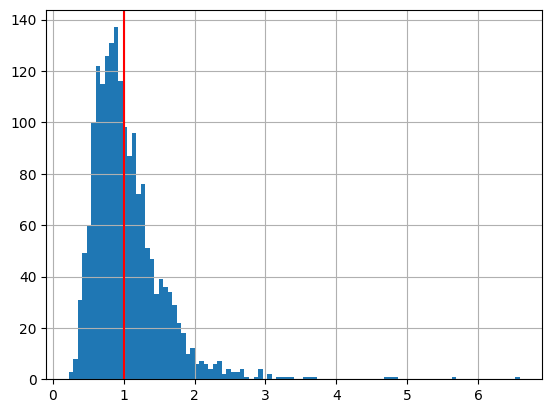

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
nutrient_ratio['Iron'].hist(bins=100)
plt.axvline(x = 1, color = 'r', label = 'axvline - full height')

In [22]:
# Below is the percentage of households with at least one child 0-8 in Uganda that are below recommended iron levels
percent_households_under_rdi = len(nutrient_ratio[nutrient_ratio['Iron']<1])/len(nutrient_ratio['Iron'])
print(percent_households_under_rdi)
print(nutrient_ratio['Iron'].mean())

0.5530054644808743
1.0511811928828787


## Iron content of beans and millet

Beans (fresh and dry) and millet have significant amounts of iron in them, as shown by the FCT results below

In [92]:
fct.loc[['Beans (dry)', 'Beans (fresh)', 'Millet']]['Iron']

j
Beans (dry)      39.0
Beans (fresh)    66.3
Millet           39.0
Name: Iron, dtype: float64

However, these two products have very different elasticities:

Text(0.5, 0, 'Quantities of Beans Demanded')

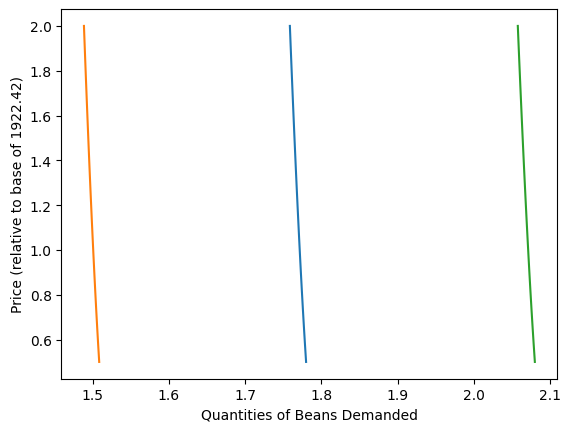

In [5]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median


# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = prices.mean()
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,p=pbar,j='Millet'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p
pbar


import matplotlib.pyplot as plt
%matplotlib inline

use = 'Beans'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Beans for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Beans for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Beans for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

## Fortification

We want to see how much iron intake would change if the iron content of beans and millet were increased through new HarvestPlus varietals. Let's create the same stats as above but with a 30% increase in the iron content of fresh and dry beans.

In [6]:
def increase_iron_content(fct, food_items, nutrient='Iron', increase_percent=30):
    new_fct = fct.to_dict()
    for food_item in food_items:
        if food_item in fct.index:
            print(f"Before update: {food_item} iron content = {fct.loc[food_item, nutrient]}")
            new_fct[nutrient][food_item] = fct.loc[food_item][nutrient] * (1 + (increase_percent / 100))
            print(f"After update: {food_item} iron content = {new_fct[nutrient][food_item]}")
        else:
            print(f"{food_item} not found in FCT.")
    return pd.DataFrame(new_fct)

# Test the function with debug statements
updated_fct = increase_iron_content(fct, ['Beans (dry)', 'Beans (fresh)', 'Millet'], nutrient='Iron', increase_percent=30)

Before update: Beans (dry) iron content = 30.0
After update: Beans (dry) iron content = 39.0
Before update: Beans (fresh) iron content = 51.0
After update: Beans (fresh) iron content = 66.3
Before update: Millet iron content = 30.0
After update: Millet iron content = 39.0


In [24]:
use = updated_fct.index.intersection(qhat.columns)
nutrients_2 = qhat[use]@updated_fct.loc[use,:]
use_nutrients2 = nutrients_2.columns.intersection(filtered_hh_rwi.columns)
nutrient_ratio_2 = (nutrients_2[use_nutrients2]/filtered_hh_rwi[use_nutrients2]).dropna()

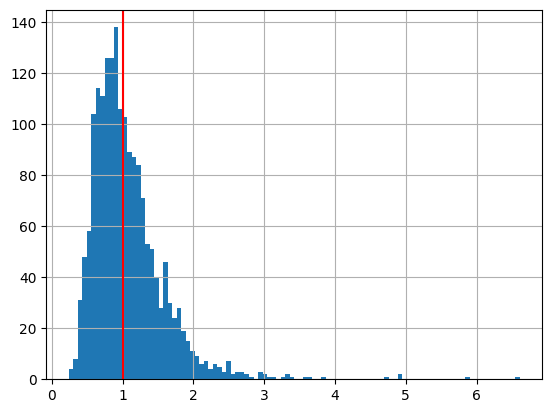

In [25]:
nutrient_ratio_2['Iron'].hist(bins=100)
plt.axvline(x = 1, color = 'r', label = 'axvline - full height')

In [23]:
percent_households_under_rdi_updated = len(nutrient_ratio_2[nutrient_ratio_2['Iron']<1])/len(nutrient_ratio_2['Iron'])
print(percent_households_under_rdi_updated)
print(nutrient_ratio_2['Iron'].mean())

0.5300546448087432
1.07879288665324
